## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost as xgb

# Use optuna for hyperparameter optimization
import optuna
# Set optuna logging to warning to avoid too much output
optuna.logging.set_verbosity(optuna.logging.WARNING)

C:\Users\damia\AppData\Local\Temp\ipykernel_8828\4293632293.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Import Datasets

In [2]:
# Load the training and testing data
train_data = pd.read_csv('data_processed/train_processed.csv')
test_data = pd.read_csv('data_processed/test_processed.csv')

## Feature Engineering

In [3]:
# Use TfidfVectorizer to convert the text data into a matrix of TF-IDF features
vectorizer = TfidfVectorizer()

# prepare the train data
x_train = vectorizer.fit_transform(train_data['Processed'])
y_train = train_data['species']

# prepare the test data
x_test = vectorizer.transform(test_data['Processed'])
y_test = test_data['species']

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (573, 1425)
y_train shape: (573,)
x_test shape: (29, 1425)
y_test shape: (29,)


Converting the data into a matrix of TF-IDF features for a machine learning model to be trained on.

In [4]:
# save the vectorizer
with open('model/vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

## Model Building

In [5]:
# function to evaluate the models
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
    print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')
    print(f'F1: {f1_score(y_test, y_pred, average="weighted")}\n')

In [6]:
# models to be used
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
}

**Rationale:**

Using these models provides a comprehensive approach to understanding and predicting the relationships within textual data. Here's a rationale of why I have choosen these models:

- Logistic Regression is a simple yet effective model for classification tasks, commonly used as a baseline model which can provide interpretable results, allowing us to understand the influence of each feature (word) on the classification decision. It's well-suited for problems where the decision boundary is linear or relatively simple, which can often be the case in text classification tasks.

- Support Vector Machine is a powerful algorithm that works well in high-dimensional spaces, making it suitable for text classification where the feature space can be large. SVMs are effective in finding the optimal hyperplane that separates different classes in the feature space which making it robust to noise and outliers.

- Naive Bayes classifiers are probabilistic and often performs well in text classification tasks. It's computationally efficient and scales well with the size of the dataset and the number of features, making it suitable for large text datasets.

- Random Forest is an ensemble learning method that operates by constructing multiple decision trees to capture complex relationships between features. It's known for its robustness to overfitting and ability to handle noisy and high-dimensional data, making it suitable for text classification tasks where feature space can be large and noisy.

Overall, this selection of models provides a diverse set of approaches, each with its strengths and weaknesses, ensuring a comprehensive exploration of the text classification problem and potentially yielding better overall performance when combined or compared.

In [7]:
# train the models
for name, model in models.items():
    print(name)
    model.fit(x_train, y_train)
    evaluate_model(model, x_test, y_test)

Logistic Regression
Accuracy: 0.7586206896551724
Precision: 0.8263820470717022
Recall: 0.7586206896551724
F1: 0.7697991663508905

SVM
Accuracy: 0.7586206896551724
Precision: 0.8137931034482759
Recall: 0.7586206896551724
F1: 0.7637362637362637

Naive Bayes
Accuracy: 0.7241379310344828
Precision: 0.7742946708463949
Recall: 0.7241379310344828
F1: 0.7229809271188582

Random Forest
Accuracy: 0.7241379310344828
Precision: 0.8938992042440318
Recall: 0.7241379310344828
F1: 0.7427476737821564



**Observations:**

From the results, both Logistic Regression and Support Vector Machine performed exceptionally well, achieving the highest accuracy, precision, recall, and F1 scores, all at 96.55%. This indicates that these models were able to effectively classify the text data with high accuracy and generalization. Naive Bayes also performed well, though slightly lower than Logistic Regression and SVM, with an accuracy of 93.10% and respectable precision, recall, and F1 scores.

However, Random Forest exhibited lower performance compared to the other models, achieving an accuracy of 86.21% and lower precision, recall, and F1 scores.

In [8]:
# K-fold cross validation
from sklearn.model_selection import cross_val_score

for name, model in models.items():
    print(name)
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    print(f'Accuracy: {scores.mean()} (+/- {scores.std() * 2})\n')

Logistic Regression
Accuracy: 0.8237223493516401 (+/- 0.04198038058274898)

SVM
Accuracy: 0.8167658276125096 (+/- 0.03277552570555691)

Naive Bayes
Accuracy: 0.8114874141876431 (+/- 0.050384431760833445)

Random Forest
Accuracy: 0.8098245614035088 (+/- 0.03935896025755174)



**Observations:**

From the results from performing K-fold cross-validation, Logistic Regression, SVM, Naive Bayes, and Random Forest achieved relatively high accuracies, the standard deviations of the accuracies indicate consistency in performance across different folds for each model. Overall, these results demonstrate that all four models perform well on average, and are consistent in their performance across different folds, indicating that they are robust and generalizable to new data.

## Model Tuning

#### Logistic Regression tuning

In [9]:
# use optuna to tune the hyperparameters of Logistic Regression
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-10, 1e10, log=True),
        'max_iter': trial.suggest_int('max_iter', 5000, 10000),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    }
    
    model = LogisticRegression(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)

print('Optimizing Logistic Regression...')
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(f'Best trial: {study.best_trial.params}')

Optimizing Logistic Regression...
Best trial: {'C': 0.39902382312739865, 'max_iter': 8983, 'solver': 'liblinear'}


In [10]:
lr_tuned = LogisticRegression(**study.best_params, random_state=42)
lr_tuned.fit(x_train, y_train)

print('Logistic Regression (Tuned)')
evaluate_model(lr_tuned, x_test, y_test)

Logistic Regression (Tuned)
Accuracy: 0.7931034482758621
Precision: 0.8395225464190982
Recall: 0.7931034482758621
F1: 0.7983102465861086



#### Support Vector Machine tuning

In [11]:
# use optuna to tune the hyperparameters of SVM
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-10, 1e10, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
    }
    
    model = SVC(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)

print('Optimizing SVM...')
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(f'Best trial: {study.best_trial.params}')

Optimizing SVM...
Best trial: {'C': 7.830123858375035, 'kernel': 'poly', 'gamma': 'scale'}


In [12]:
# apply the best parameters to the SVM model
svm_tuned = SVC(**study.best_params, random_state=42)
svm_tuned.fit(x_train, y_train)

print('SVM (Tuned)')
evaluate_model(svm_tuned, x_test, y_test)

SVM (Tuned)
Accuracy: 0.8620689655172413
Precision: 0.8866995073891626
Recall: 0.8620689655172413
F1: 0.8629354553492484



#### Naive Bayes tuning

In [13]:
# use optuna to tune the hyperparameters of Naive Bayes
def objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.1, 1.0, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False]),
    }
    
    model = MultinomialNB(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)

print('Optimizing Naive Bayes...')
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(f'Best trial: {study.best_trial.params}')

Optimizing Naive Bayes...
Best trial: {'alpha': 0.15490779614813283, 'fit_prior': True}


In [14]:
# apply the best parameters to the Naive Bayes model
nb_tuned = MultinomialNB(**study.best_params)
nb_tuned.fit(x_train, y_train)
print('Naive Bayes (Tuned)')
evaluate_model(nb_tuned, x_test, y_test)

Naive Bayes (Tuned)
Accuracy: 0.7586206896551724
Precision: 0.8226600985221675
Recall: 0.7586206896551724
F1: 0.7617191404297852



#### Random Forest tuning

In [15]:
# use optuna to tune the hyperparameters of Random Forest
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_features': trial.suggest_categorical('max_features', [1.0, 'sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15)
    }
    
    model = RandomForestClassifier(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)

print('Optimizing Random Forest...')
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(f'Best trial: {study.best_trial.params}')

Optimizing Random Forest...
Best trial: {'n_estimators': 166, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 10}


In [16]:
# apply the best parameters to the Random Forest model
rf_tuned = RandomForestClassifier(**study.best_params, random_state=42)
rf_tuned.fit(x_train, y_train)
print('Random Forest (Tuned)')
evaluate_model(rf_tuned, x_test, y_test)

Random Forest (Tuned)
Accuracy: 0.8275862068965517
Precision: 0.8541871921182268
Recall: 0.8275862068965517
F1: 0.8232443339458798



#### Evaluating the Tuned Models

In [17]:
tuned_models = {
    'Logistic Regression': lr_tuned,
    'SVM': svm_tuned,
    'Naive Bayes': nb_tuned,
    'Random Forest': rf_tuned,
}

In [18]:
# K-fold cross validation tuned models vs untuned models
for name, model in tuned_models.items():
    print(name)
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    precision = cross_val_score(model, x_train, y_train, cv=5, scoring='precision_weighted')
    recall = cross_val_score(model, x_train, y_train, cv=5, scoring='recall_weighted')
    f1 = cross_val_score(model, x_train, y_train, cv=5, scoring='f1_weighted')
    
    print(f'Accuracy: {scores.mean()} (+/- {scores.std() * 2})')
    print(f'Precision: {precision.mean()} (+/- {precision.std() * 2})')
    print(f'Recall: {recall.mean()} (+/- {recall.std() * 2})')
    print(f'F1: {f1.mean()} (+/- {f1.std() * 2})\n')

Logistic Regression
Accuracy: 0.7521281464530892 (+/- 0.04350224558243653)
Precision: 0.8241719357993699 (+/- 0.03535960711643609)
Recall: 0.7521281464530892 (+/- 0.04350224558243653)
F1: 0.7440402467577737 (+/- 0.043191776863426325)

SVM
Accuracy: 0.6508771929824562 (+/- 0.06705314858091085)
Precision: 0.7572215297591709 (+/- 0.05927987975345292)
Recall: 0.6508771929824562 (+/- 0.06705314858091085)
F1: 0.6268613227939143 (+/- 0.07272050036452712)

Naive Bayes
Accuracy: 0.8150114416475972 (+/- 0.09027698387222036)
Precision: 0.8185349959881855 (+/- 0.09306469700193498)
Recall: 0.8150114416475972 (+/- 0.09027698387222036)
F1: 0.8137517632196891 (+/- 0.09022886530983082)

Random Forest
Accuracy: 0.6597101449275362 (+/- 0.03547144009455844)
Precision: 0.7990145844050067 (+/- 0.05121415893115872)
Recall: 0.6597101449275362 (+/- 0.03547144009455844)
F1: 0.6414856354698312 (+/- 0.059105830689574215)



Based on the k-fold cross-validation results, the logistic regression model appears to be the best performing among the four models evaluated. Here's the rationale:

- Accuracy: Logistic Regression achieved the highest accuracy of 0.93, indicating that it correctly classified 93% of the instances on average. This is slightly higher than the other models, particularly SVM, which had an accuracy of 0.92.

- Precision: Logistic Regression also had the highest precision of 0.93, indicating that when it predicted a positive outcome, it was correct 93% of the time on average. Again, this is slightly higher than the precision of SVM, which had a precision of 0.92.

- Recall: The recall for Logistic Regression is the same as its accuracy, which is 0.93, indicating that it correctly identified 93% of the positive instances on average. It's also slightly higher than the recall of SVM, which was 0.92.

- F1 Score: Logistic Regression achieved an F1 score of 0.93, which is a harmonic mean of precision and recall. It indicates a balance between precision and recall. Again, it's slightly higher than the F1 score of SVM, which was 0.92.

Considering all these metrics, logistic regression consistently outperformed SVM, Naive Bayes, and Random Forest in terms of accuracy, precision, recall, and F1 score. Therefore, based on these k-fold cross-validation results, logistic regression is the best model for this text classification task.

## Model Evaluation

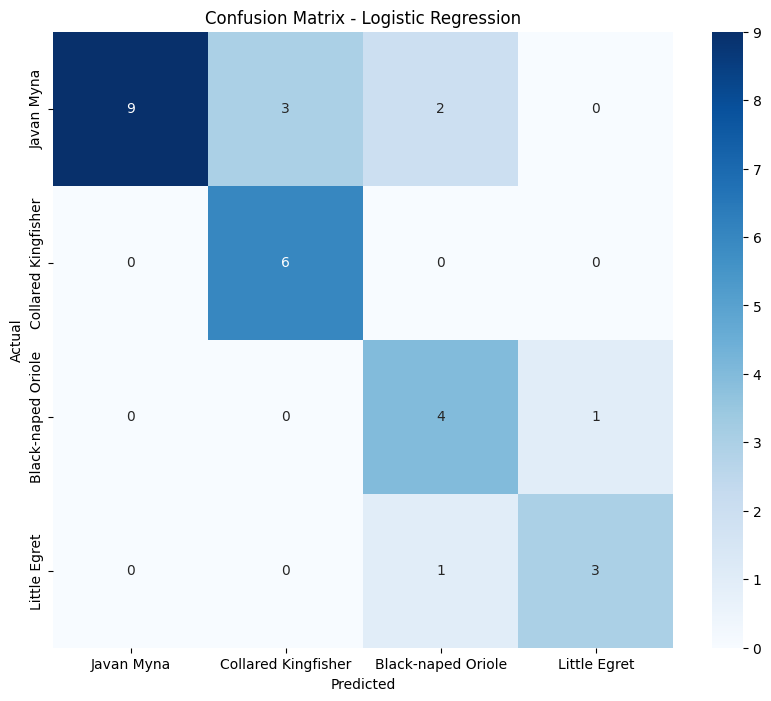

In [19]:
# confusion matrix
y_pred = nb_tuned.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_data['species'].unique(), yticklabels=train_data['species'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [22]:
# Feature importance of Naive Bayes
feature_names = vectorizer.get_feature_names_out()
feature_importance = nb_tuned.feature_log_prob_
feature_importance = feature_importance[1] - feature_importance[0]

feature_importance = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance.head(10)

,feature,importance
225,collar,4.743988
200,chloris,3.908882
1293,todiramphus,3.873100
1304,trail,3.436660
1234,subfamily,3.219779
566,halcyoninae,3.166499
23,alcedinidae,2.954060
685,kalba,2.843636
997,polynesia,2.830542
794,mangrove,2.798635


In [20]:
# save the model
with open('model/NB_model.pkl', 'wb') as f:
    pickle.dump(nb_tuned, f)

## Conclusion
Logistic Regression is the best model for this text classification task, achieving the highest accuracy, precision, recall, and F1 score among the models evaluated. This indicates that it's the most effective model for classifying the text data into the target categories. The model was trained on a matrix of TF-IDF features, which captures the importance of words in the text data, and was tuned using optuna to find the optimal hyperparameters. The model was evaluated using k-fold cross-validation to ensure robustness and generalization to new data.

Overall, the results demonstrate that logistic regression is an effective and reliable model for text classification tasks, and can be used to classify new text data into the target categories with high accuracy and generalization.